In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import bicgstab
import Reader as rd
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
from scipy.misc import imread
import bcolz

import os

#### Methods

$normalization = v^{T}Dv$

$correlation = \frac{(v^{T}Ds)^2} {normalization}$

$score = \frac{v^{T}Lv}{normalization}$

In [2]:
def e_neighbour_graph(img, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            result[row * colN + col][(row + rowDiff) * colN + (col + colDiff)] = 1
    return result


def fully_connected_graph(img, sigma):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for row2 in range(rowN):
                for col2 in range(colN):
                    weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                    result[row * colN + col][row2 * colN + col2] = weight
    return result


def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    return result

def laplacian(graph):
    diag = np.diag(sum(graph))
    lap = diag - graph
    return [lap, diag]


def orthogonalize(diag, s):
    nodeNum = len(diag)
    p = np.ones((nodeNum, 1)) / pow(sum(np.diag(np.diag(sum(diag)))), .5)
    projection = np.dot(np.transpose(s), np.dot(diag, p))
    v = s - projection[0][0] * p
    # return [v, projection]
    return v


def PRwalk(graph, alpha, s):
    if alpha < 0:
        print('Error: alpha must be positive!')
        return -1
    nodeNum = len(graph)
    [L, D] = laplacian(graph)
    s = orthogonalize(D, s)
    v, flag = bicgstab((L + alpha * D), np.dot(D, s),tol=1e-3, maxiter=nodeNum)

    v = np.reshape(v, (len(v), 1))

    v = orthogonalize(D, v)
    return v

def PRobjective(graph, seed, myImg):
    
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    print('Threshold: ' + str(1 / len(graph)))
    alphaList = []    
    correlationList = []
    scoreList = []
    valueList = []
    
    exponential = 1
    correlation = 1 / len(graph) + 1 # to get into loop
    
    MAXITER = 29
    MINITER = 4
    for i in range(MAXITER):
        if correlation > 1 / len(graph):
            oldCorrelation = correlation
            exponential -= 1
            alpha = 2 ** exponential
            v = PRwalk(graph, alpha, s)
            normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
            correlation = \
                (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
            score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
            alphaList.append(alpha)
            correlationList.append(correlation)
            scoreList.append(score)
            valueList.append(v)
            
            print('--')
            print('alpha: 2^' + str(exponential))
            print('Correlation: ' + str(correlation))
            print('Score: ' + str(score))
            print('Heatmap:\n')
            heat = np.zeros(myImg.shape)
            for ii in range(myImg.shape[0]):
                for jj in range(myImg.shape[1]):
                    heat[ii][jj] = v[ii * myImg.shape[1] + jj]    
            plt.imshow(heat, cmap='hot', interpolation='nearest')
            plt.show()
            
        if i == MINITER:
            print('**')
            print('Starting correlation decrease check!')
            
        if i >= MINITER and oldCorrelation * .99 < correlation:
            break
            
    print('****')
    plt.plot(correlationList, scoreList, 'r*--')
    plt.xlabel('Correlation')
    plt.ylabel('Score')
    plt.show()
    
    return [alphaList, correlationList, scoreList, valueList]

def normalize(D, s):
    norm = np.dot(np.dot(np.transpose(s), D), s)
    v = s/math.sqrt(norm)
    return v

def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

#### Image

In [3]:
# 1a10297e6c3101af33003e6c4f846f47
IMAGE = "1a10297e6c3101af33003e6c4f846f47"
myImg = np.asarray(imread(IMAGE + "/" + IMAGE + ".aps.jpg"), dtype=np.int)
# 148 row, 176 columns
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
seedList = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1', [40,90],[40,65],[45,123],[30,100]]
for i in range(25, 122, 48):
    for j in range(60, 125, 32):
        seedList.append([i,j])
alphaListList = []
correlationListList = []
scoreListList = []
valueListList = []

#### Trying seed as normalised full image

$seed[i] = \frac{intensity[i]}{\sqrt{\sum intensity^2}}$

Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.999609277212
Score: 0.00284619627768
Heatmap:



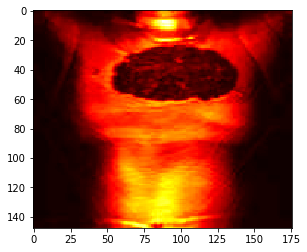

--
alpha: 2^-1
Correlation: 0.999100221702
Score: 0.00249159658409
Heatmap:



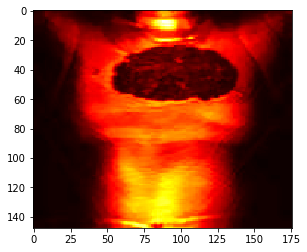

--
alpha: 2^-2
Correlation: 0.998186253305
Score: 0.00216857517055
Heatmap:



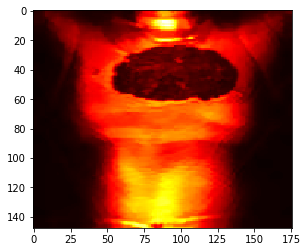

--
alpha: 2^-3
Correlation: 0.996669527778
Score: 0.00189847414363
Heatmap:



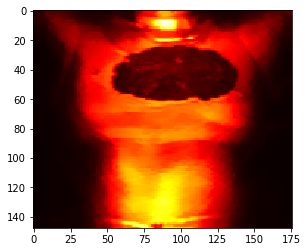

--
alpha: 2^-4
Correlation: 0.994198397598
Score: 0.00167644078187
Heatmap:



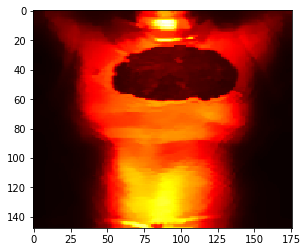

**
Starting correlation decrease check!
****


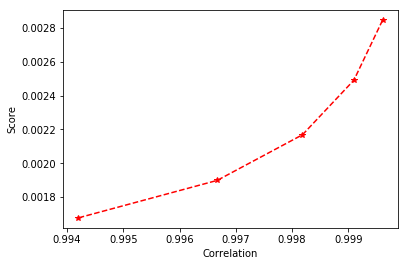

In [4]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed / math.sqrt(sum(sum(seed * seed)))

[alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

# Saving
alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

#### Trying seed as normalised Intensity Square to between 0 and 1

$seed[i] = \frac{intensity[i]^2 - min(intensity^2)}{max(intensity^2) - min(intensity^2)}$

Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.999462646036
Score: 0.00376256947974
Heatmap:



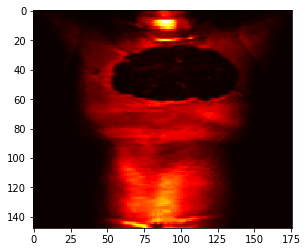

--
alpha: 2^-1
Correlation: 0.998750297027
Score: 0.00326426888037
Heatmap:



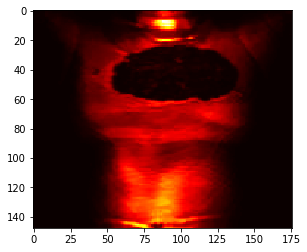

--
alpha: 2^-2
Correlation: 0.997429003009
Score: 0.00279753860944
Heatmap:



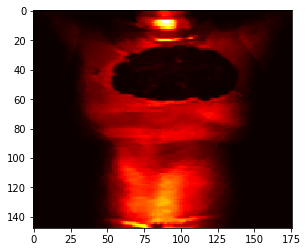

--
alpha: 2^-3
Correlation: 0.995123171349
Score: 0.00238673896867
Heatmap:



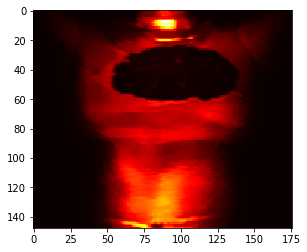

--
alpha: 2^-4
Correlation: 0.991180414718
Score: 0.00203073896722
Heatmap:



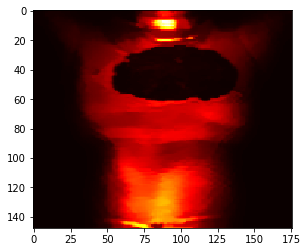

**
Starting correlation decrease check!
****


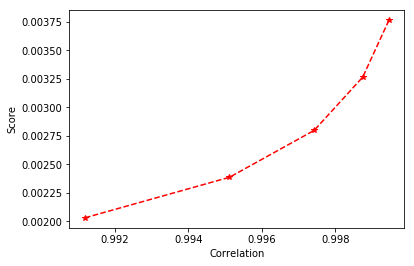

In [5]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed * seed
seed = (seed - min(seed)) / (max(seed) - min(seed))

[alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

# Saving
alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

#### Trying seedList that is randomly taken in and outside of threat

--------Seed [40, 90]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.979509808791
Score: 0.846963786643
Heatmap:



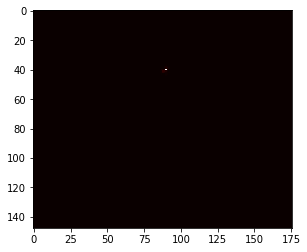

--
alpha: 2^-1
Correlation: 0.946911477422
Score: 0.795829431707
Heatmap:



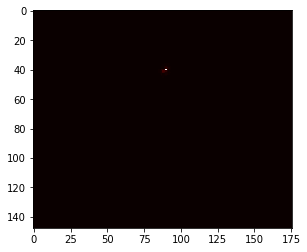

--
alpha: 2^-2
Correlation: 0.882322357777
Score: 0.717909408462
Heatmap:



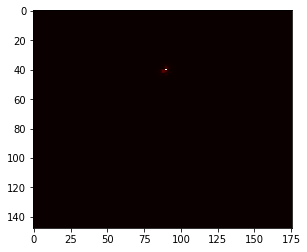

--
alpha: 2^-3
Correlation: 0.775766690166
Score: 0.610198996165
Heatmap:



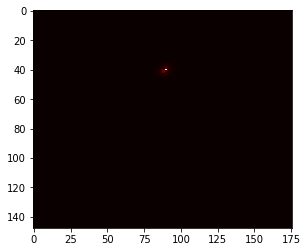

--
alpha: 2^-4
Correlation: 0.628033869137
Score: 0.477383665113
Heatmap:



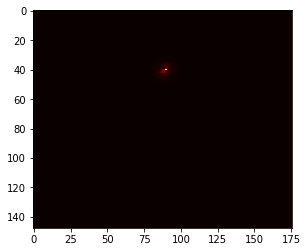

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.458988170279
Score: 0.337137000658
Heatmap:



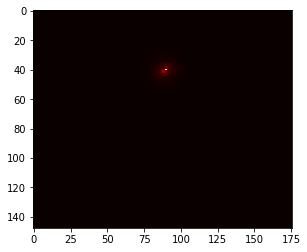

--
alpha: 2^-6
Correlation: 0.2973519427
Score: 0.210740403305
Heatmap:



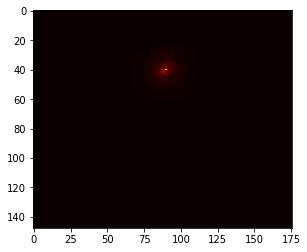

--
alpha: 2^-7
Correlation: 0.164514024058
Score: 0.111756804487
Heatmap:



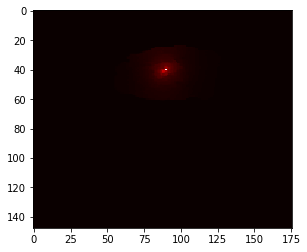

--
alpha: 2^-8
Correlation: 0.0763552714362
Score: 0.0489790533935
Heatmap:



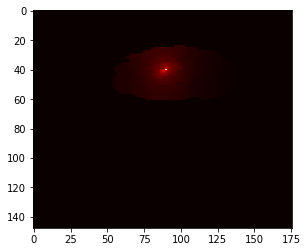

--
alpha: 2^-9
Correlation: 0.0310263836821
Score: 0.018304246976
Heatmap:



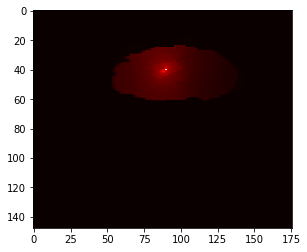

--
alpha: 2^-10
Correlation: 0.0127295214906
Score: 0.00671109975807
Heatmap:



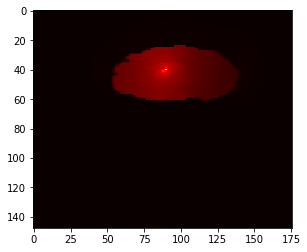

--
alpha: 2^-11
Correlation: 0.0059406158583
Score: 0.00276482724251
Heatmap:



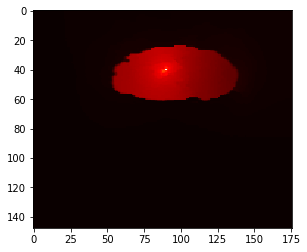

--
alpha: 2^-12
Correlation: 0.0033740075994
Score: 0.00141752628092
Heatmap:



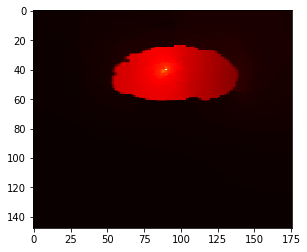

--
alpha: 2^-13
Correlation: 0.00229314854973
Score: 0.000904902133787
Heatmap:



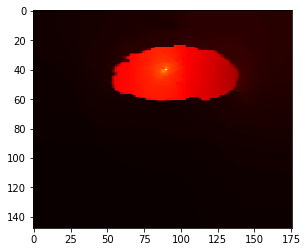

--
alpha: 2^-14
Correlation: 0.00181875523132
Score: 0.000698094628287
Heatmap:



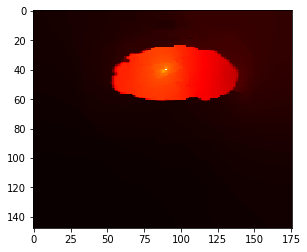

--
alpha: 2^-15
Correlation: 0.00159002953583
Score: 0.000603889855239
Heatmap:



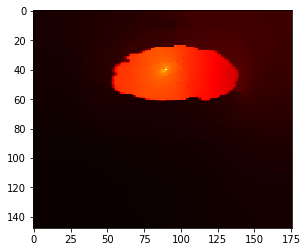

--
alpha: 2^-16
Correlation: 0.00147843296425
Score: 0.000559528269246
Heatmap:



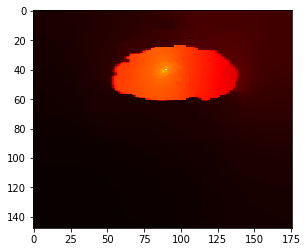

--
alpha: 2^-17
Correlation: 0.00142088688389
Score: 0.000537097292953
Heatmap:



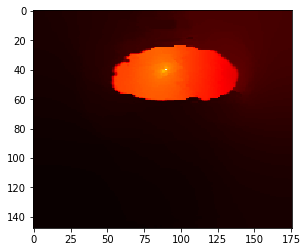

--
alpha: 2^-18
Correlation: 0.0013926989236
Score: 0.000526232116708
Heatmap:



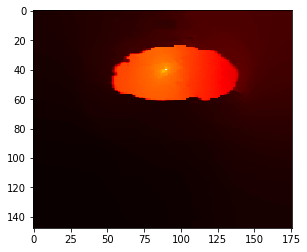

--
alpha: 2^-19
Correlation: 0.00137253703263
Score: 0.000518486496471
Heatmap:



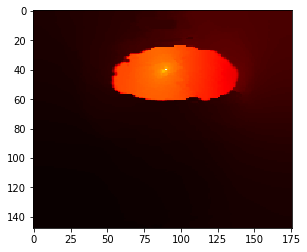

--
alpha: 2^-20
Correlation: 0.00137671561313
Score: 0.000520050825737
Heatmap:



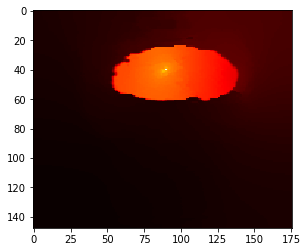

****


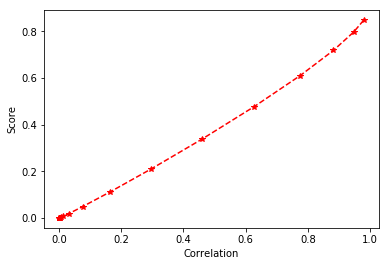

--------Seed [40, 65]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.977513063251
Score: 0.862859535467
Heatmap:



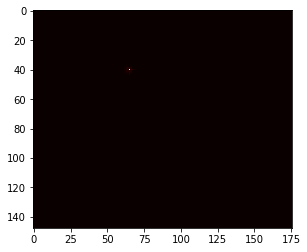

--
alpha: 2^-1
Correlation: 0.940954381883
Score: 0.804893110868
Heatmap:



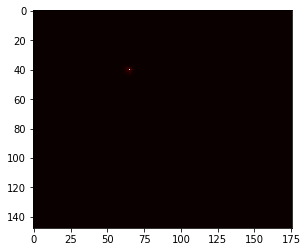

--
alpha: 2^-2
Correlation: 0.866748650947
Score: 0.71420169046
Heatmap:



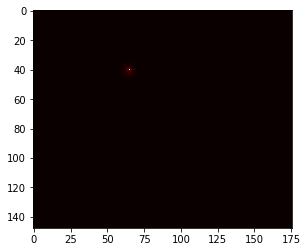

--
alpha: 2^-3
Correlation: 0.736337437891
Score: 0.580761223698
Heatmap:



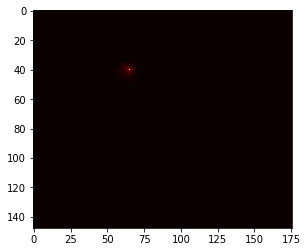

--
alpha: 2^-4
Correlation: 0.547593541935
Score: 0.409798820028
Heatmap:



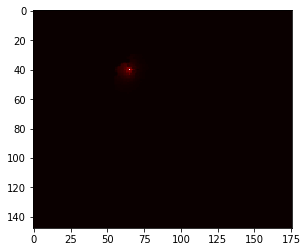

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.34291480784
Score: 0.240525346448
Heatmap:



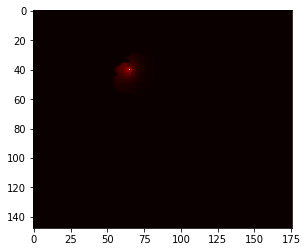

--
alpha: 2^-6
Correlation: 0.183876630156
Score: 0.118974676195
Heatmap:



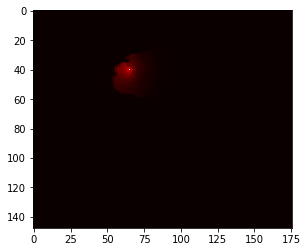

--
alpha: 2^-7
Correlation: 0.0900789668509
Score: 0.0527653662126
Heatmap:



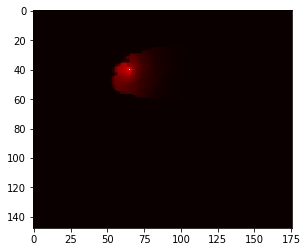

--
alpha: 2^-8
Correlation: 0.0437556130384
Score: 0.0228294189321
Heatmap:



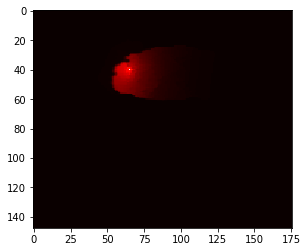

--
alpha: 2^-9
Correlation: 0.0220305278358
Score: 0.0101283033973
Heatmap:



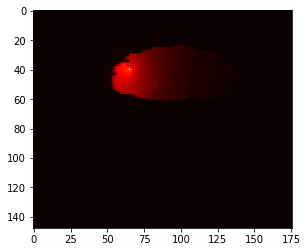

--
alpha: 2^-10
Correlation: 0.0117277756772
Score: 0.0047363665522
Heatmap:



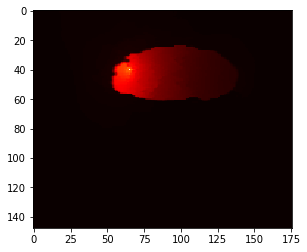

--
alpha: 2^-11
Correlation: 0.00646613472898
Score: 0.00229332112812
Heatmap:



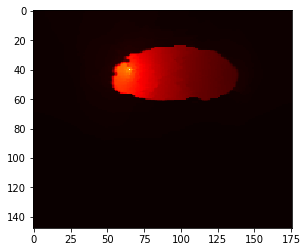

--
alpha: 2^-12
Correlation: 0.00403559917304
Score: 0.00129618765317
Heatmap:



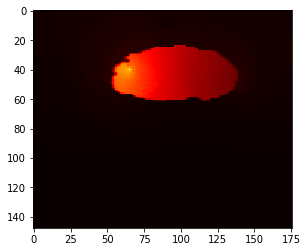

--
alpha: 2^-13
Correlation: 0.00292366139462
Score: 0.000887478586246
Heatmap:



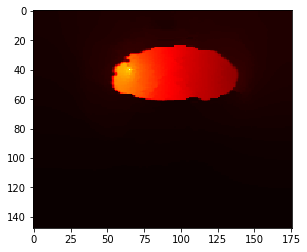

--
alpha: 2^-14
Correlation: 0.002339546009
Score: 0.0006907151825
Heatmap:



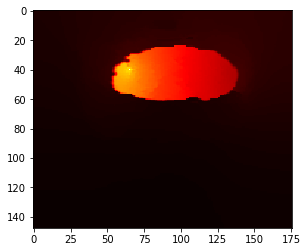

--
alpha: 2^-15
Correlation: 0.00208097458298
Score: 0.000608785430571
Heatmap:



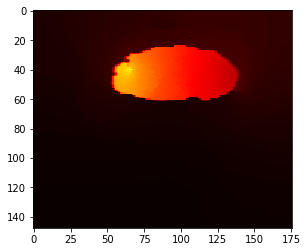

--
alpha: 2^-16
Correlation: 0.00192240522123
Score: 0.000560078476512
Heatmap:



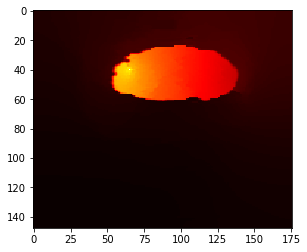

--
alpha: 2^-17
Correlation: 0.00189090449858
Score: 0.00055081647761
Heatmap:



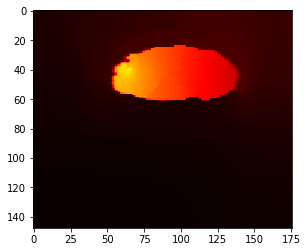

--
alpha: 2^-18
Correlation: 0.00183935980803
Score: 0.000535486911663
Heatmap:



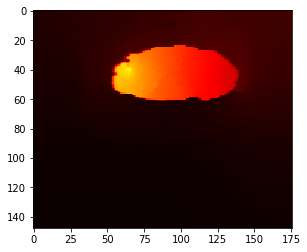

--
alpha: 2^-19
Correlation: 0.00182257067142
Score: 0.000530465695973
Heatmap:



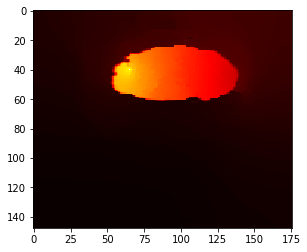

****


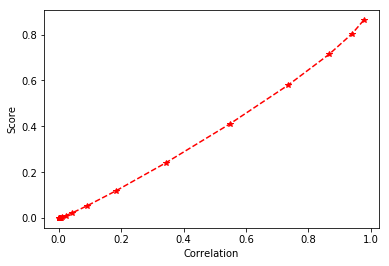

--------Seed [45, 123]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.977487136622
Score: 0.879804067723
Heatmap:



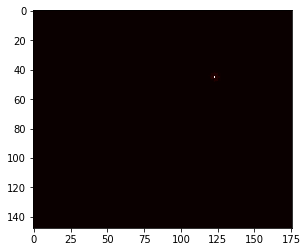

--
alpha: 2^-1
Correlation: 0.938024923072
Score: 0.816671134172
Heatmap:



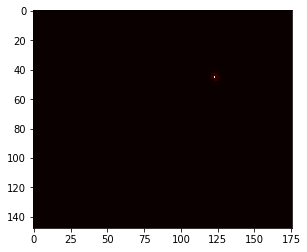

--
alpha: 2^-2
Correlation: 0.854351888582
Score: 0.713104587714
Heatmap:



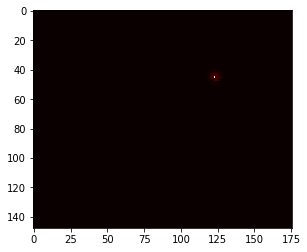

--
alpha: 2^-3
Correlation: 0.715188857035
Score: 0.568689292043
Heatmap:



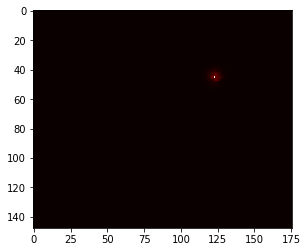

--
alpha: 2^-4
Correlation: 0.539403212166
Score: 0.407502163556
Heatmap:



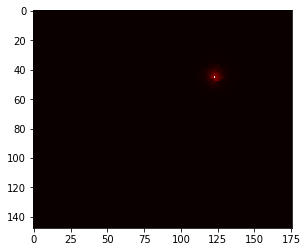

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.361948235247
Score: 0.259150183726
Heatmap:



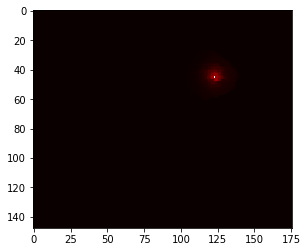

--
alpha: 2^-6
Correlation: 0.208164534835
Score: 0.139877130738
Heatmap:



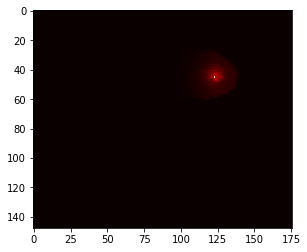

--
alpha: 2^-7
Correlation: 0.103347905429
Score: 0.0640164614487
Heatmap:



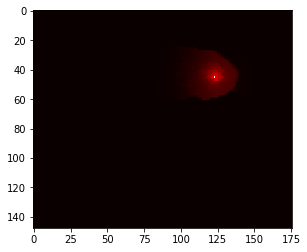

--
alpha: 2^-8
Correlation: 0.0478764841881
Score: 0.0267453464056
Heatmap:



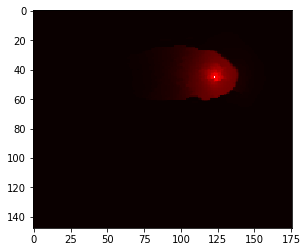

--
alpha: 2^-9
Correlation: 0.022119855675
Score: 0.0108981797092
Heatmap:



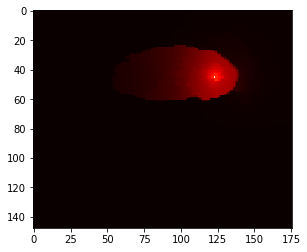

--
alpha: 2^-10
Correlation: 0.0113656867882
Score: 0.00492507423704
Heatmap:



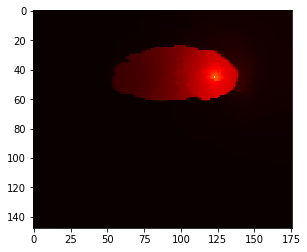

--
alpha: 2^-11
Correlation: 0.00590665367487
Score: 0.00221803052485
Heatmap:



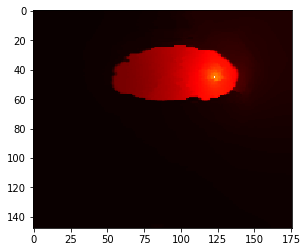

--
alpha: 2^-12
Correlation: 0.00354489529985
Score: 0.00118774917456
Heatmap:



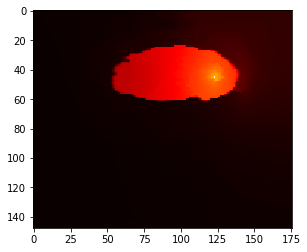

--
alpha: 2^-13
Correlation: 0.00248210159466
Score: 0.000776241287156
Heatmap:



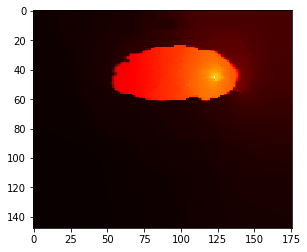

--
alpha: 2^-14
Correlation: 0.00197637177118
Score: 0.000598357438949
Heatmap:



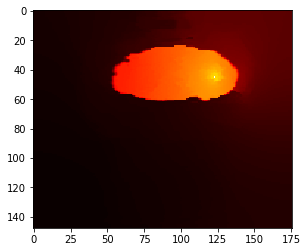

--
alpha: 2^-15
Correlation: 0.00173733458235
Score: 0.000519813150283
Heatmap:



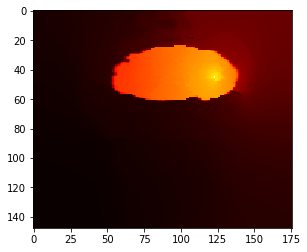

--
alpha: 2^-16
Correlation: 0.00161185232606
Score: 0.000480192941598
Heatmap:



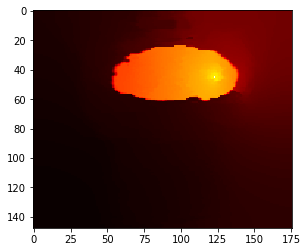

--
alpha: 2^-17
Correlation: 0.0015670451624
Score: 0.000466435918368
Heatmap:



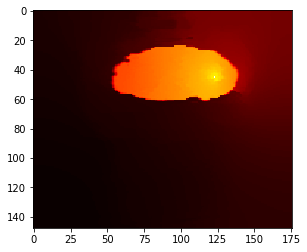

--
alpha: 2^-18
Correlation: 0.00153802176783
Score: 0.000457658033839
Heatmap:



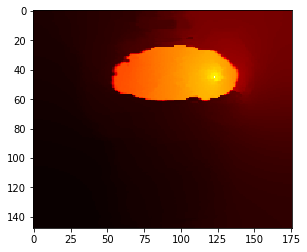

--
alpha: 2^-19
Correlation: 0.00154772443956
Score: 0.000460436369163
Heatmap:



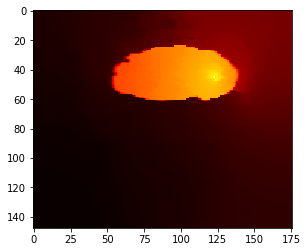

****


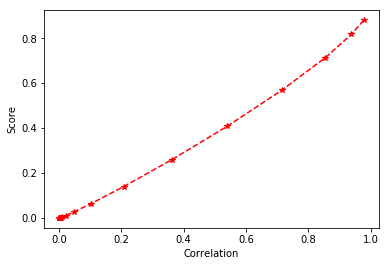

--------Seed [30, 100]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.978329207884
Score: 0.865353679424
Heatmap:



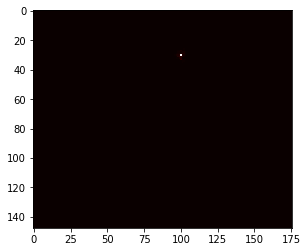

--
alpha: 2^-1
Correlation: 0.941299481312
Score: 0.80665828434
Heatmap:



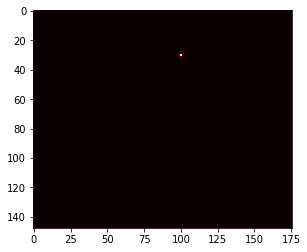

--
alpha: 2^-2
Correlation: 0.862179922231
Score: 0.709906924688
Heatmap:



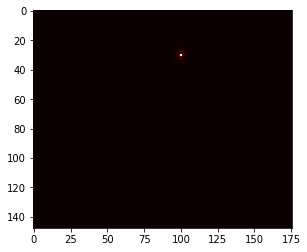

--
alpha: 2^-3
Correlation: 0.723478135357
Score: 0.567945819046
Heatmap:



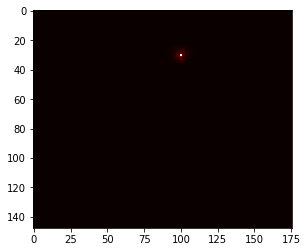

--
alpha: 2^-4
Correlation: 0.533935015083
Score: 0.396536962413
Heatmap:



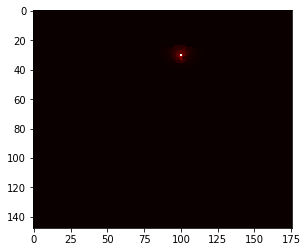

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.342969268999
Score: 0.239231261628
Heatmap:



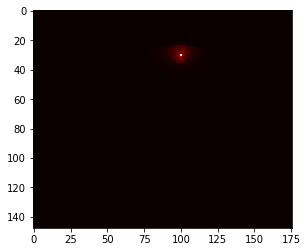

--
alpha: 2^-6
Correlation: 0.200183145784
Score: 0.130572020641
Heatmap:



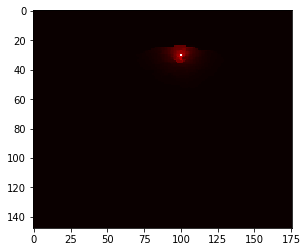

--
alpha: 2^-7
Correlation: 0.110924996922
Score: 0.0674814085925
Heatmap:



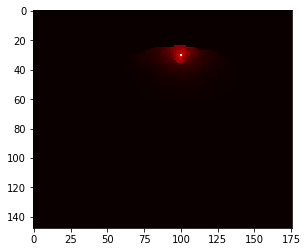

--
alpha: 2^-8
Correlation: 0.0577454359405
Score: 0.0325241973923
Heatmap:



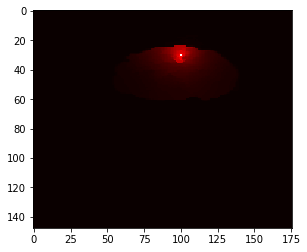

--
alpha: 2^-9
Correlation: 0.0275042337069
Score: 0.0140778928677
Heatmap:



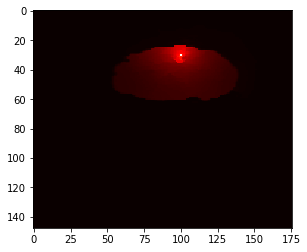

--
alpha: 2^-10
Correlation: 0.0126692551648
Score: 0.0057495346853
Heatmap:



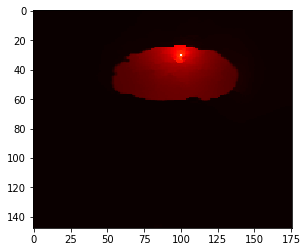

--
alpha: 2^-11
Correlation: 0.00620779348741
Score: 0.00246355789958
Heatmap:



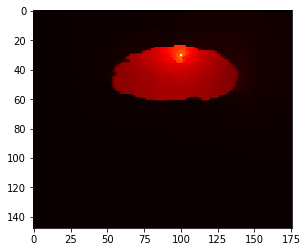

--
alpha: 2^-12
Correlation: 0.00361487370873
Score: 0.00128602836353
Heatmap:



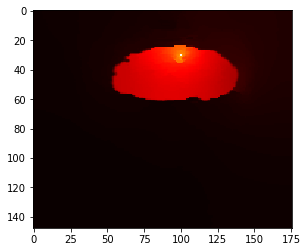

--
alpha: 2^-13
Correlation: 0.00249554733186
Score: 0.000831075270612
Heatmap:



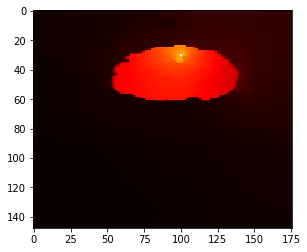

--
alpha: 2^-14
Correlation: 0.00199012868728
Score: 0.000643275210596
Heatmap:



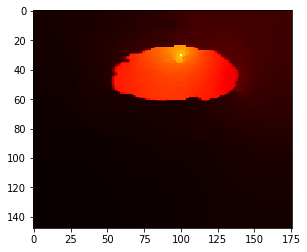

--
alpha: 2^-15
Correlation: 0.00174076314675
Score: 0.000556269529359
Heatmap:



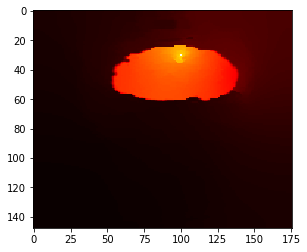

--
alpha: 2^-16
Correlation: 0.00162573605759
Score: 0.000517592506685
Heatmap:



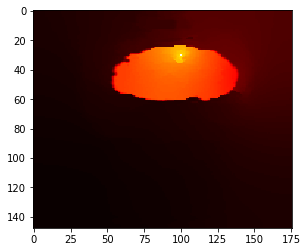

--
alpha: 2^-17
Correlation: 0.00155777767321
Score: 0.000495290559481
Heatmap:



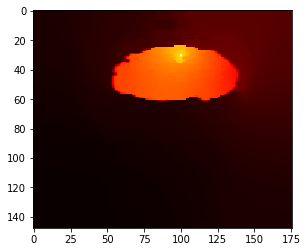

--
alpha: 2^-18
Correlation: 0.0015493515504
Score: 0.000492442615133
Heatmap:



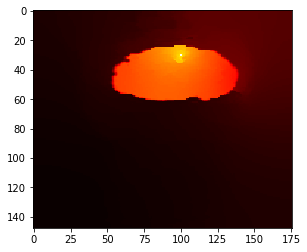

****


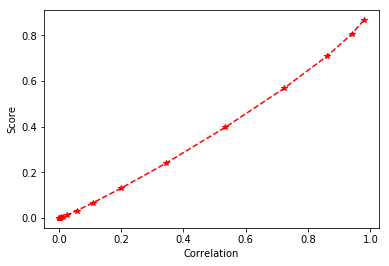

--------Seed [25, 60]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.970851073387
Score: 0.843245607292
Heatmap:



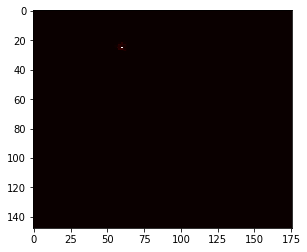

--
alpha: 2^-1
Correlation: 0.920601584201
Score: 0.764075482367
Heatmap:



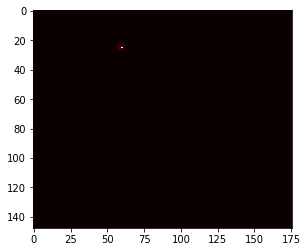

--
alpha: 2^-2
Correlation: 0.819072593446
Score: 0.641725956469
Heatmap:



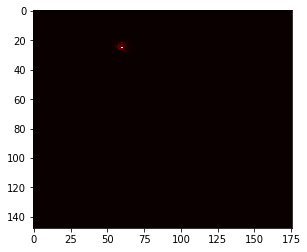

--
alpha: 2^-3
Correlation: 0.664802078572
Score: 0.488149707165
Heatmap:



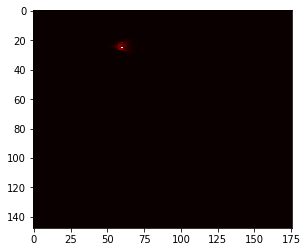

--
alpha: 2^-4
Correlation: 0.489195169188
Score: 0.336159157605
Heatmap:



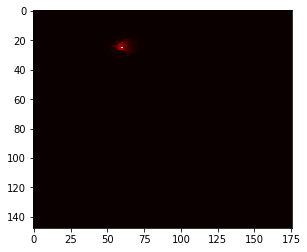

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.329651502245
Score: 0.212258422873
Heatmap:



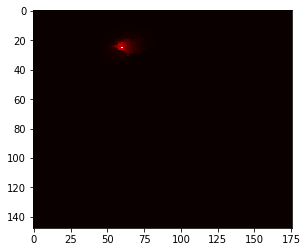

--
alpha: 2^-6
Correlation: 0.20658848633
Score: 0.124850812634
Heatmap:



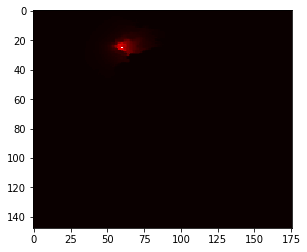

--
alpha: 2^-7
Correlation: 0.122788977508
Score: 0.0697692098199
Heatmap:



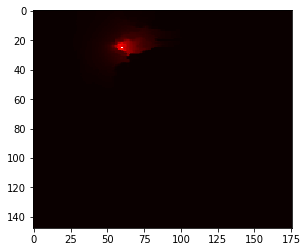

--
alpha: 2^-8
Correlation: 0.0703395115372
Score: 0.0376282090404
Heatmap:



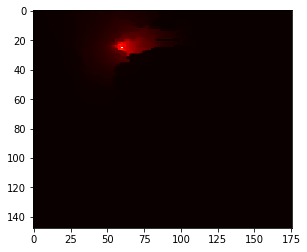

--
alpha: 2^-9
Correlation: 0.0398589143645
Score: 0.0201219177488
Heatmap:



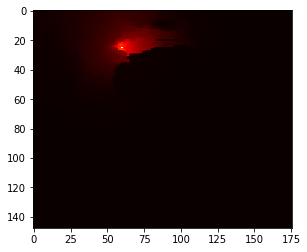

--
alpha: 2^-10
Correlation: 0.02231783883
Score: 0.0106457033643
Heatmap:



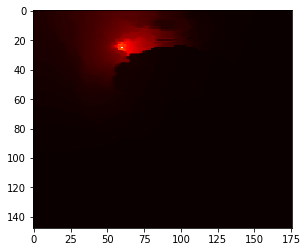

--
alpha: 2^-11
Correlation: 0.01292013131
Score: 0.00585953627337
Heatmap:



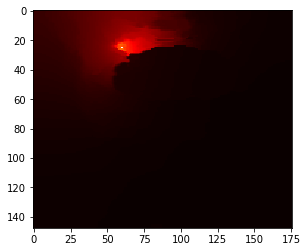

--
alpha: 2^-12
Correlation: 0.00820414084959
Score: 0.00358482397247
Heatmap:



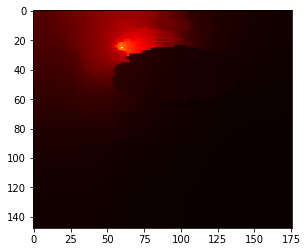

--
alpha: 2^-13
Correlation: 0.00583853431741
Score: 0.00249468852112
Heatmap:



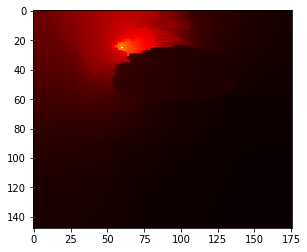

--
alpha: 2^-14
Correlation: 0.00460866218889
Score: 0.00194679814141
Heatmap:



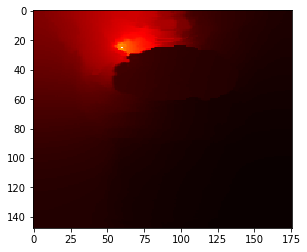

--
alpha: 2^-15
Correlation: 0.00399495792969
Score: 0.00167947380991
Heatmap:



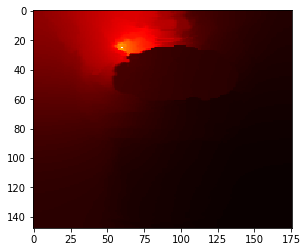

--
alpha: 2^-16
Correlation: 0.00372966771434
Score: 0.00156553149196
Heatmap:



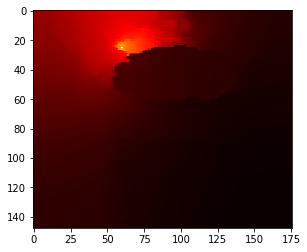

--
alpha: 2^-17
Correlation: 0.00357635961839
Score: 0.00150007212683
Heatmap:



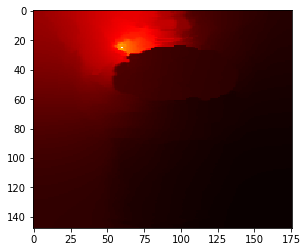

--
alpha: 2^-18
Correlation: 0.00350511573283
Score: 0.00146980255457
Heatmap:



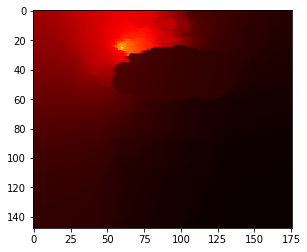

--
alpha: 2^-19
Correlation: 0.00344768350514
Score: 0.00144542328452
Heatmap:



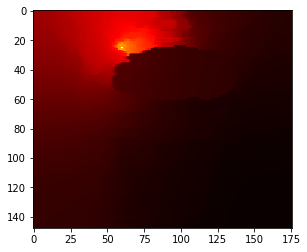

--
alpha: 2^-20
Correlation: 0.0034952229476
Score: 0.0014654473912
Heatmap:



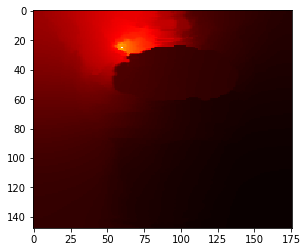

****


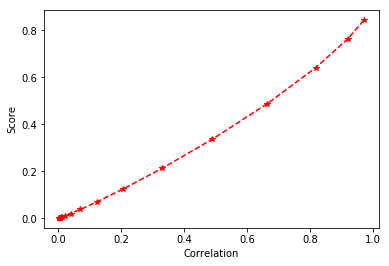

--------Seed [25, 92]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.977572456507
Score: 0.82574787259
Heatmap:



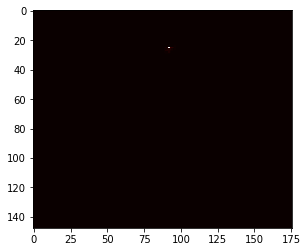

--
alpha: 2^-1
Correlation: 0.941008139894
Score: 0.769185123155
Heatmap:



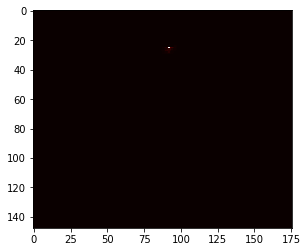

--
alpha: 2^-2
Correlation: 0.865181040998
Score: 0.679378218399
Heatmap:



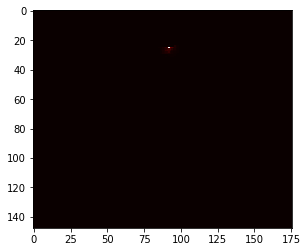

--
alpha: 2^-3
Correlation: 0.73819334895
Score: 0.554209408236
Heatmap:



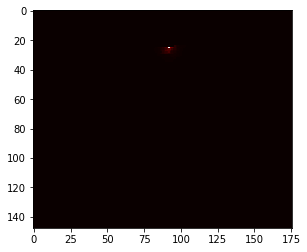

--
alpha: 2^-4
Correlation: 0.569354574935
Score: 0.407560828737
Heatmap:



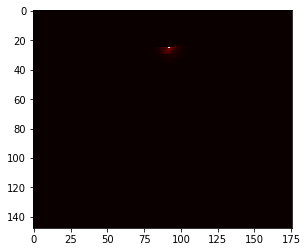

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.392669708986
Score: 0.267585413924
Heatmap:



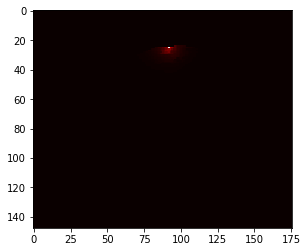

--
alpha: 2^-6
Correlation: 0.244985490161
Score: 0.158757283756
Heatmap:



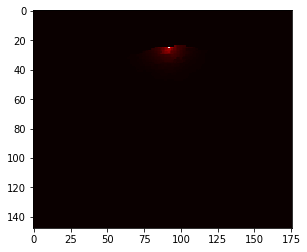

--
alpha: 2^-7
Correlation: 0.141967619856
Score: 0.0874123367584
Heatmap:



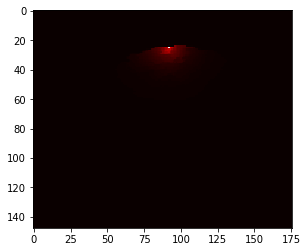

--
alpha: 2^-8
Correlation: 0.0765355902627
Score: 0.0446197580283
Heatmap:



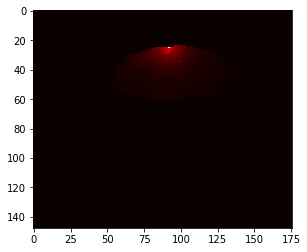

--
alpha: 2^-9
Correlation: 0.0372545931627
Score: 0.0203302403428
Heatmap:



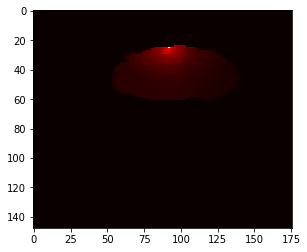

--
alpha: 2^-10
Correlation: 0.0166855144036
Score: 0.0083554989688
Heatmap:



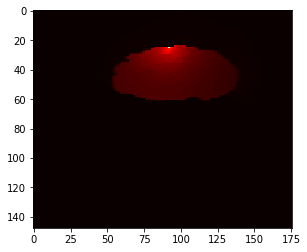

--
alpha: 2^-11
Correlation: 0.00791241247096
Score: 0.00359932323422
Heatmap:



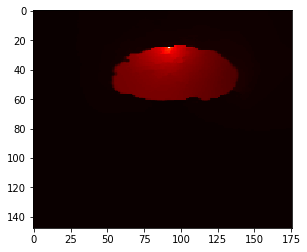

--
alpha: 2^-12
Correlation: 0.00435502386864
Score: 0.00182172222723
Heatmap:



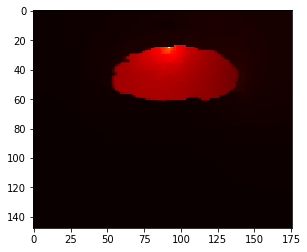

--
alpha: 2^-13
Correlation: 0.00288198283039
Score: 0.00114354062086
Heatmap:



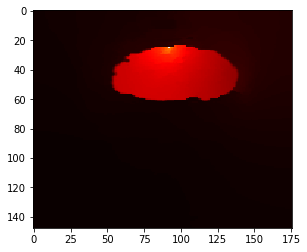

--
alpha: 2^-14
Correlation: 0.0022054522668
Score: 0.000852715594696
Heatmap:



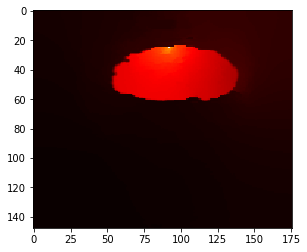

--
alpha: 2^-15
Correlation: 0.00191560561803
Score: 0.000734162928984
Heatmap:



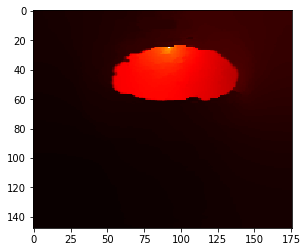

--
alpha: 2^-16
Correlation: 0.00175037491887
Score: 0.000668530911194
Heatmap:



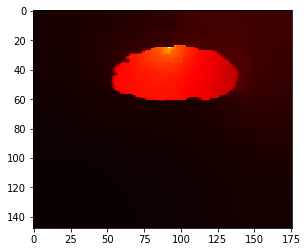

--
alpha: 2^-17
Correlation: 0.00168275350687
Score: 0.000642105078329
Heatmap:



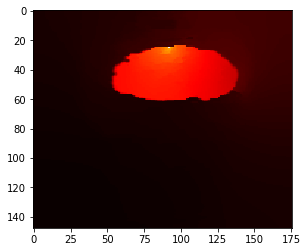

--
alpha: 2^-18
Correlation: 0.00165054957414
Score: 0.000629453055188
Heatmap:



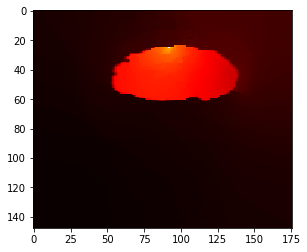

--
alpha: 2^-19
Correlation: 0.00162035631402
Score: 0.000617951366194
Heatmap:



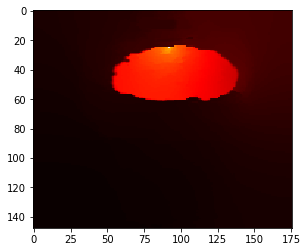

--
alpha: 2^-20
Correlation: 0.00161137356296
Score: 0.000614420329755
Heatmap:



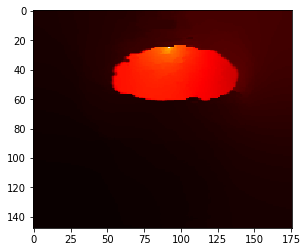

****


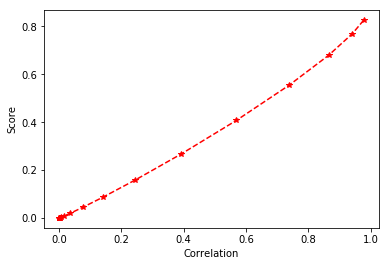

--------Seed [25, 124]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.976240126064
Score: 0.87236427894
Heatmap:



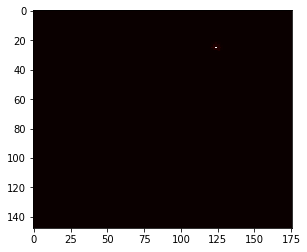

--
alpha: 2^-1
Correlation: 0.933529702833
Score: 0.804310429555
Heatmap:



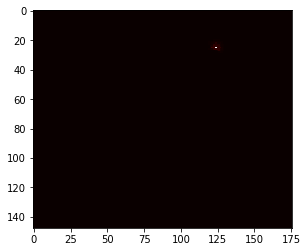

--
alpha: 2^-2
Correlation: 0.839712311588
Score: 0.688969314982
Heatmap:



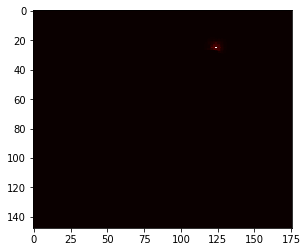

--
alpha: 2^-3
Correlation: 0.681105832173
Score: 0.526261544792
Heatmap:



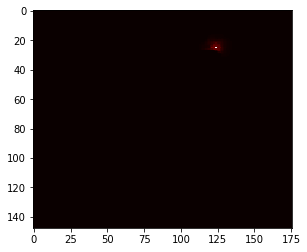

--
alpha: 2^-4
Correlation: 0.484146704145
Score: 0.3490530679
Heatmap:



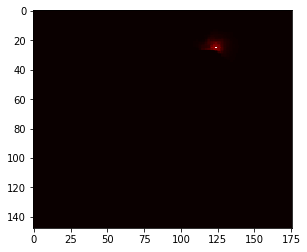

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.304959660599
Score: 0.20379577729
Heatmap:



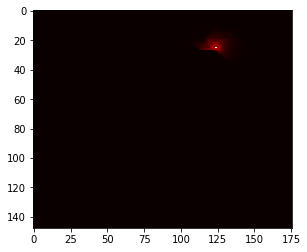

--
alpha: 2^-6
Correlation: 0.178291971628
Score: 0.11008603142
Heatmap:



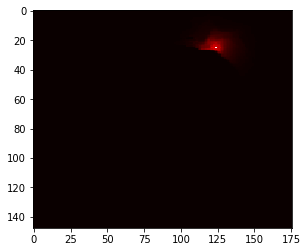

--
alpha: 2^-7
Correlation: 0.101572712598
Score: 0.0579929744001
Heatmap:



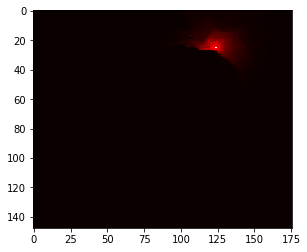

--
alpha: 2^-8
Correlation: 0.0573516977088
Score: 0.0303485118105
Heatmap:



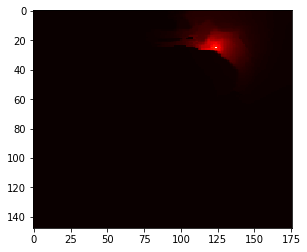

--
alpha: 2^-9
Correlation: 0.0317873331033
Score: 0.0155950063878
Heatmap:



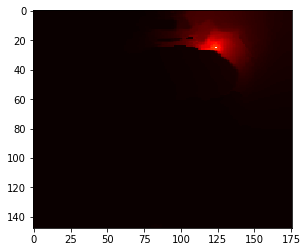

--
alpha: 2^-10
Correlation: 0.0172695457421
Score: 0.00784170269074
Heatmap:



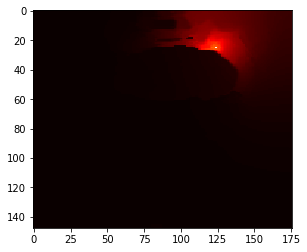

--
alpha: 2^-11
Correlation: 0.00974630573191
Score: 0.00411900693465
Heatmap:



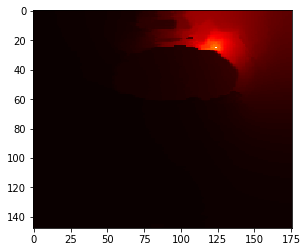

--
alpha: 2^-12
Correlation: 0.0060058227962
Score: 0.00239842752517
Heatmap:



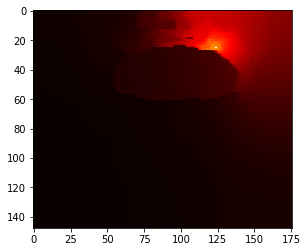

--
alpha: 2^-13
Correlation: 0.00415840516578
Score: 0.00160094920845
Heatmap:



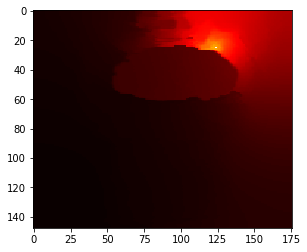

--
alpha: 2^-14
Correlation: 0.00318421237837
Score: 0.0012021145994
Heatmap:



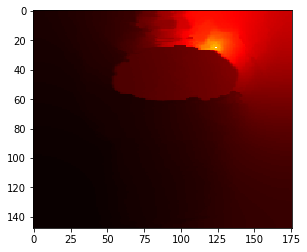

--
alpha: 2^-15
Correlation: 0.00272164909827
Score: 0.0010192657499
Heatmap:



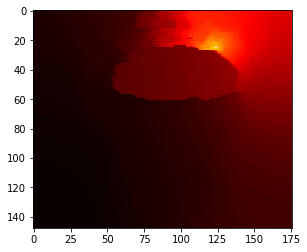

--
alpha: 2^-16
Correlation: 0.00253007988913
Score: 0.000944993499749
Heatmap:



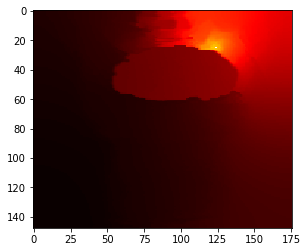

--
alpha: 2^-17
Correlation: 0.00237151398759
Score: 0.000883644044061
Heatmap:



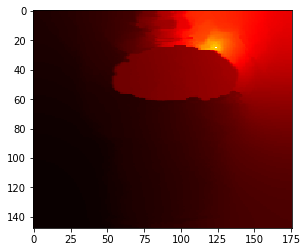

--
alpha: 2^-18
Correlation: 0.00230214325189
Score: 0.000857862739092
Heatmap:



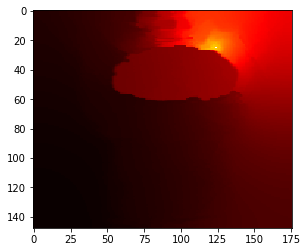

--
alpha: 2^-19
Correlation: 0.00228147197298
Score: 0.000850175386484
Heatmap:



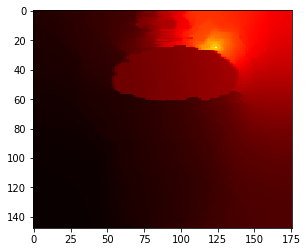

****


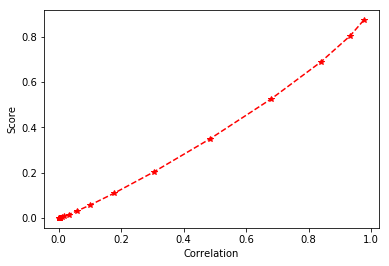

--------Seed [73, 60]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.979725721824
Score: 0.894780273
Heatmap:



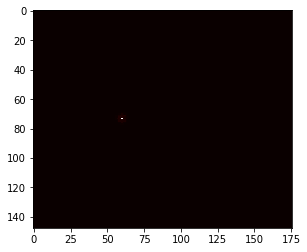

--
alpha: 2^-1
Correlation: 0.94297785681
Score: 0.835596387678
Heatmap:



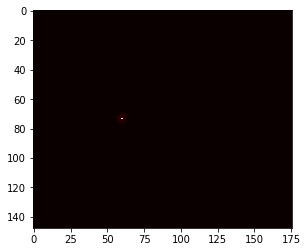

--
alpha: 2^-2
Correlation: 0.859782514296
Score: 0.731553510833
Heatmap:



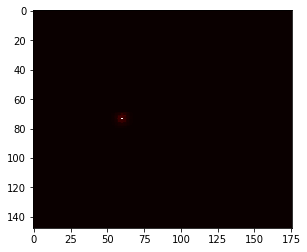

--
alpha: 2^-3
Correlation: 0.70940125274
Score: 0.573401868328
Heatmap:



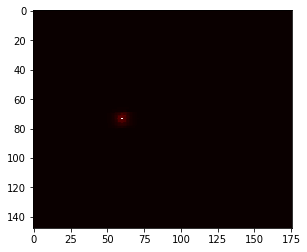

--
alpha: 2^-4
Correlation: 0.511781157659
Score: 0.3895077579
Heatmap:



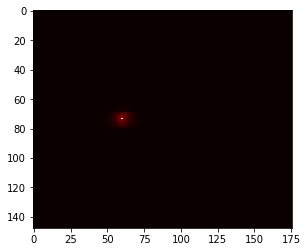

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.326369010625
Score: 0.232597764659
Heatmap:



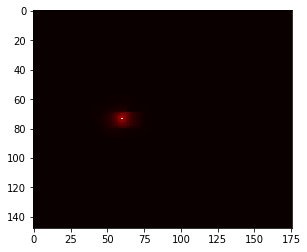

--
alpha: 2^-6
Correlation: 0.191799074297
Score: 0.12767161894
Heatmap:



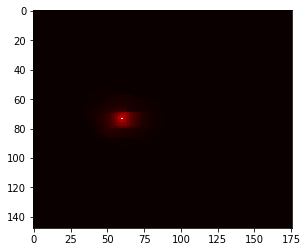

--
alpha: 2^-7
Correlation: 0.108588834508
Score: 0.0675231055088
Heatmap:



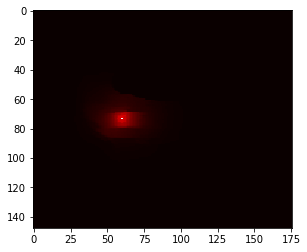

--
alpha: 2^-8
Correlation: 0.0612981198084
Score: 0.0357136952604
Heatmap:



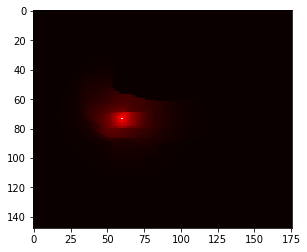

--
alpha: 2^-9
Correlation: 0.0361162614422
Score: 0.019895936249
Heatmap:



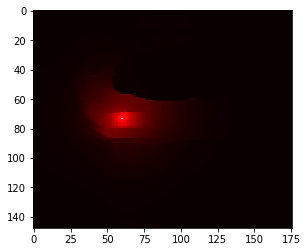

--
alpha: 2^-10
Correlation: 0.0231622612807
Score: 0.0122467886212
Heatmap:



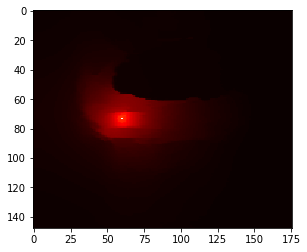

--
alpha: 2^-11
Correlation: 0.0160110806534
Score: 0.00823354733453
Heatmap:



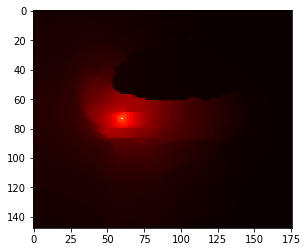

--
alpha: 2^-12
Correlation: 0.00981402965297
Score: 0.00491161375062
Heatmap:



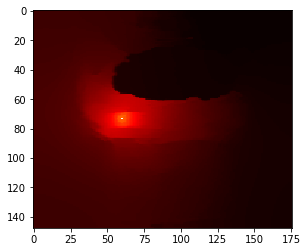

--
alpha: 2^-13
Correlation: 0.00922678844195
Score: 0.00460813240159
Heatmap:



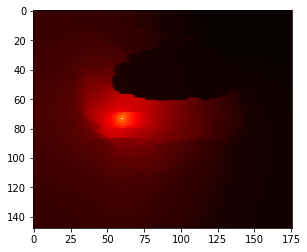

--
alpha: 2^-14
Correlation: 0.00719598957152
Score: 0.00356254333247
Heatmap:



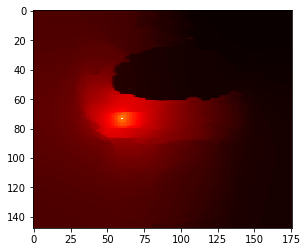

--
alpha: 2^-15
Correlation: 0.00645456507902
Score: 0.00318517388742
Heatmap:



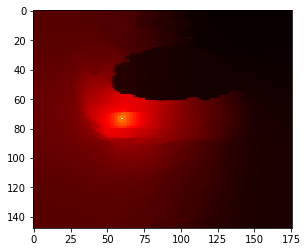

--
alpha: 2^-16
Correlation: 0.00572848736203
Score: 0.00281951345508
Heatmap:



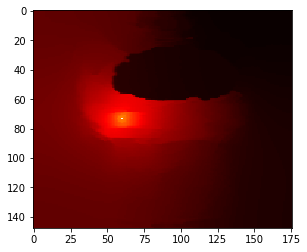

--
alpha: 2^-17
Correlation: 0.00536009389443
Score: 0.00263533293148
Heatmap:



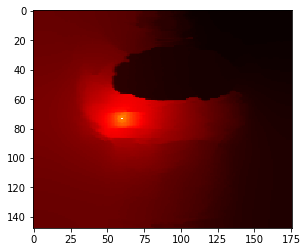

--
alpha: 2^-18
Correlation: 0.00543947203367
Score: 0.00267477499097
Heatmap:



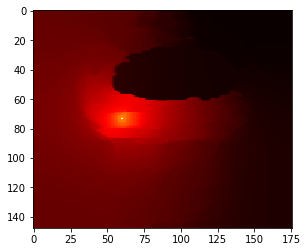

****


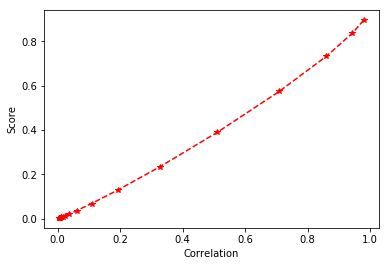

--------Seed [73, 92]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.981103275307
Score: 0.89275641756
Heatmap:



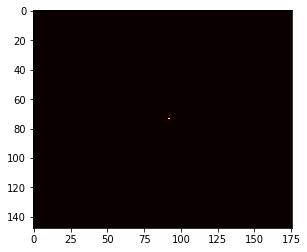

--
alpha: 2^-1
Correlation: 0.948979405324
Score: 0.841103077231
Heatmap:



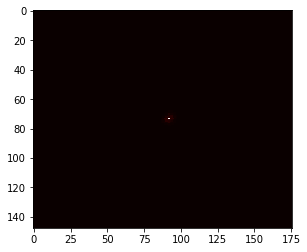

--
alpha: 2^-2
Correlation: 0.879988258263
Score: 0.754897471871
Heatmap:



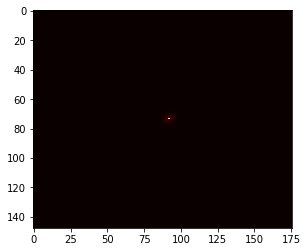

--
alpha: 2^-3
Correlation: 0.755544404683
Score: 0.62367719106
Heatmap:



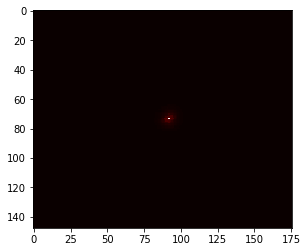

--
alpha: 2^-4
Correlation: 0.574750642554
Score: 0.453731743943
Heatmap:



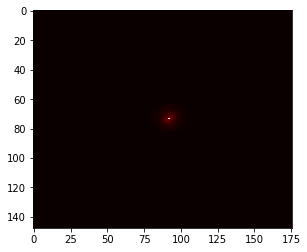

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.376420453822
Score: 0.282230122346
Heatmap:



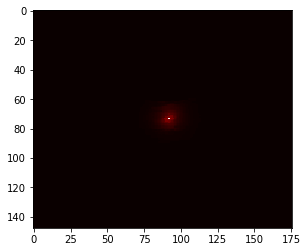

--
alpha: 2^-6
Correlation: 0.214970338442
Score: 0.151885887359
Heatmap:



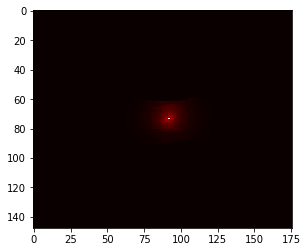

--
alpha: 2^-7
Correlation: 0.112995974832
Score: 0.0746762409828
Heatmap:



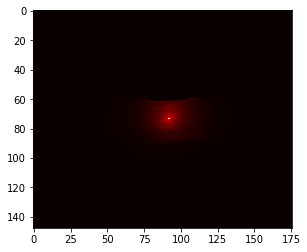

--
alpha: 2^-8
Correlation: 0.0584032264203
Score: 0.0359519944711
Heatmap:



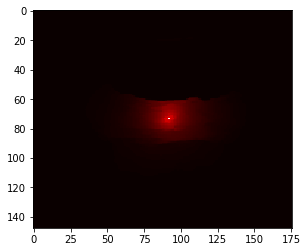

--
alpha: 2^-9
Correlation: 0.0319025937616
Score: 0.0183822756055
Heatmap:



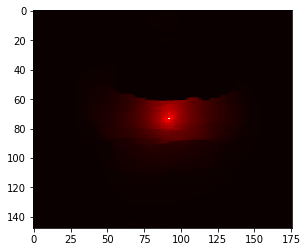

--
alpha: 2^-10
Correlation: 0.0192598667692
Score: 0.0105426689024
Heatmap:



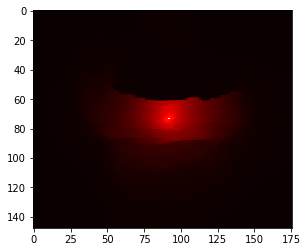

--
alpha: 2^-11
Correlation: 0.0136549458105
Score: 0.00726013220896
Heatmap:



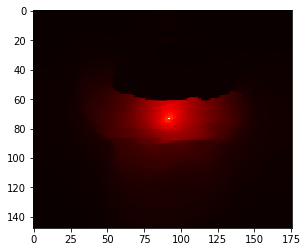

--
alpha: 2^-12
Correlation: 0.0106149398024
Score: 0.00555547400248
Heatmap:



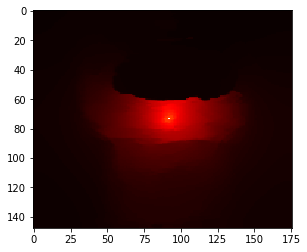

--
alpha: 2^-13
Correlation: 0.00897604022883
Score: 0.00466153104862
Heatmap:



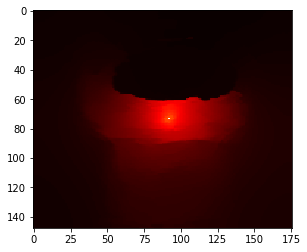

--
alpha: 2^-14
Correlation: 0.00809320872606
Score: 0.00418959797808
Heatmap:



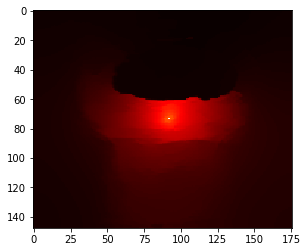

--
alpha: 2^-15
Correlation: 0.00725170403891
Score: 0.00374392292639
Heatmap:



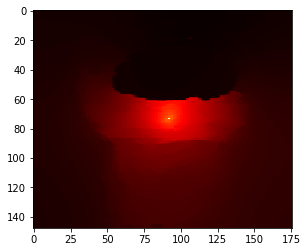

--
alpha: 2^-16
Correlation: 0.00743230326542
Score: 0.00384025528744
Heatmap:



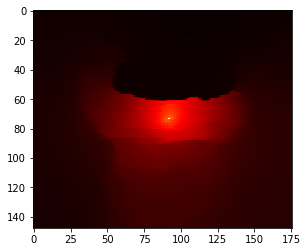

****


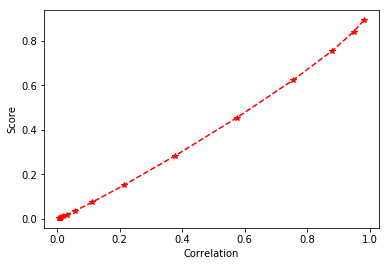

--------Seed [73, 124]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.976093046617
Score: 0.874316893334
Heatmap:



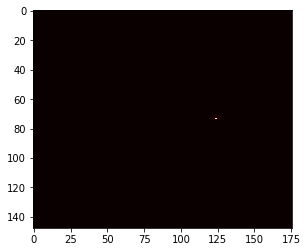

--
alpha: 2^-1
Correlation: 0.933218987949
Score: 0.805854291761
Heatmap:



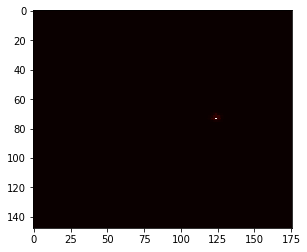

--
alpha: 2^-2
Correlation: 0.840810269698
Score: 0.691977282114
Heatmap:



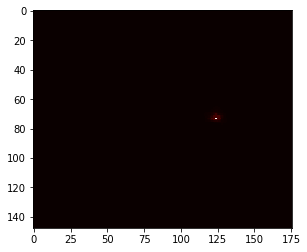

--
alpha: 2^-3
Correlation: 0.689607742714
Score: 0.536428108542
Heatmap:



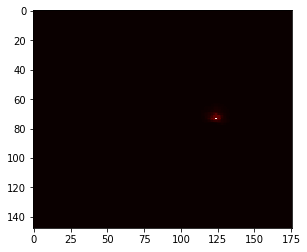

--
alpha: 2^-4
Correlation: 0.504111260197
Score: 0.368758628507
Heatmap:



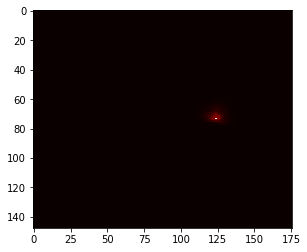

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.328103791228
Score: 0.224804640459
Heatmap:



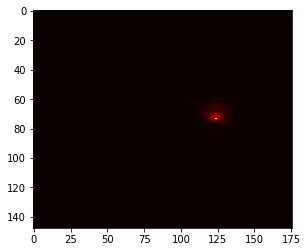

--
alpha: 2^-6
Correlation: 0.193083283742
Score: 0.12332861082
Heatmap:



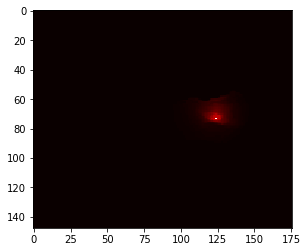

--
alpha: 2^-7
Correlation: 0.107726379631
Score: 0.0639769773796
Heatmap:



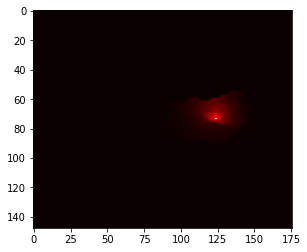

--
alpha: 2^-8
Correlation: 0.0605886136915
Score: 0.0335708933144
Heatmap:



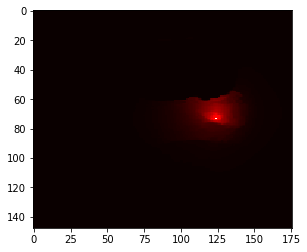

--
alpha: 2^-9
Correlation: 0.0364700119686
Score: 0.0190929419676
Heatmap:



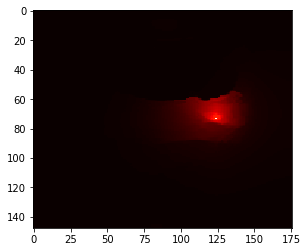

--
alpha: 2^-10
Correlation: 0.0239843419445
Score: 0.0120627538092
Heatmap:



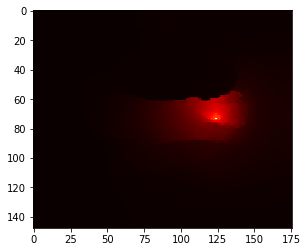

--
alpha: 2^-11
Correlation: 0.0169467442822
Score: 0.0082997737303
Heatmap:



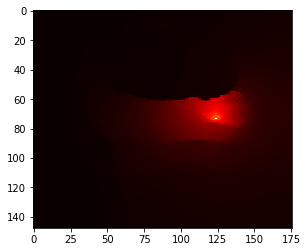

--
alpha: 2^-12
Correlation: 0.0119136910337
Score: 0.0057184107523
Heatmap:



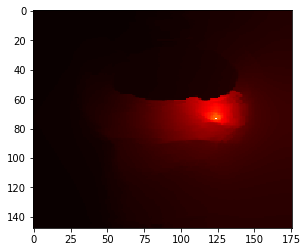

--
alpha: 2^-13
Correlation: 0.0096092824244
Score: 0.00457052395122
Heatmap:



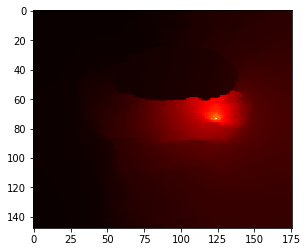

--
alpha: 2^-14
Correlation: 0.00801854712535
Score: 0.00379152940658
Heatmap:



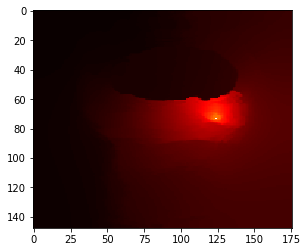

--
alpha: 2^-15
Correlation: 0.0071366840087
Score: 0.00336444404185
Heatmap:



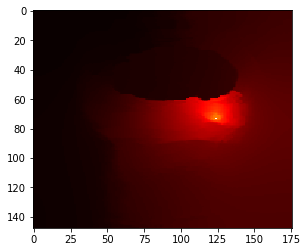

--
alpha: 2^-16
Correlation: 0.00634602087746
Score: 0.00298551481796
Heatmap:



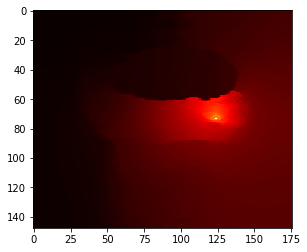

--
alpha: 2^-17
Correlation: 0.00601374767098
Score: 0.00282678665496
Heatmap:



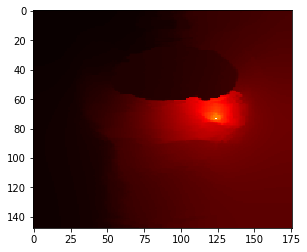

--
alpha: 2^-18
Correlation: 0.00617495026403
Score: 0.00290385071194
Heatmap:



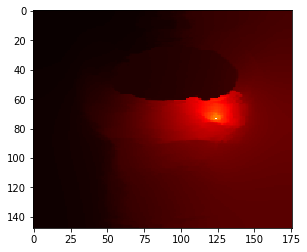

****


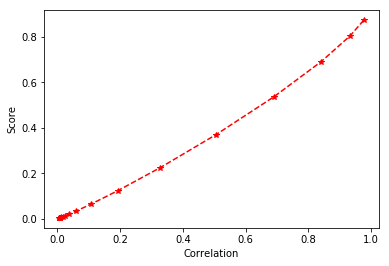

--------Seed [121, 60]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.979081650332
Score: 0.87161382432
Heatmap:



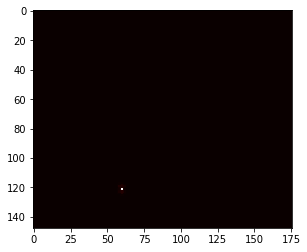

--
alpha: 2^-1
Correlation: 0.943862106145
Score: 0.815609660481
Heatmap:



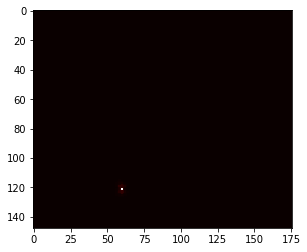

--
alpha: 2^-2
Correlation: 0.869184042374
Score: 0.723785768666
Heatmap:



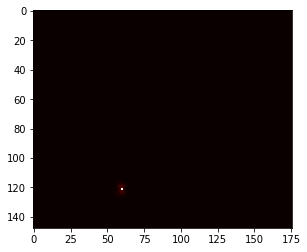

--
alpha: 2^-3
Correlation: 0.738735773887
Score: 0.58917017097
Heatmap:



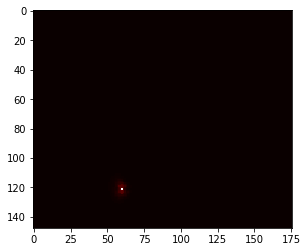

--
alpha: 2^-4
Correlation: 0.56437239675
Score: 0.429609266908
Heatmap:



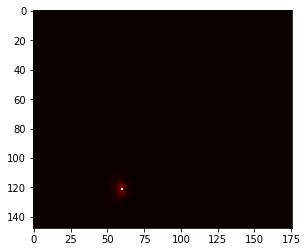

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.386280841168
Score: 0.280281152452
Heatmap:



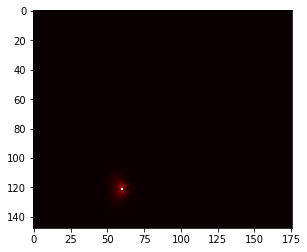

--
alpha: 2^-6
Correlation: 0.243917061262
Score: 0.168910720267
Heatmap:



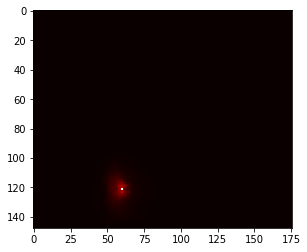

--
alpha: 2^-7
Correlation: 0.147712239219
Score: 0.0979511048569
Heatmap:



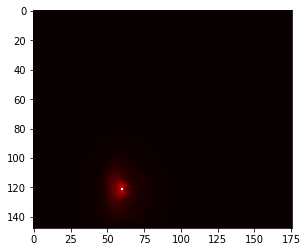

--
alpha: 2^-8
Correlation: 0.087664347552
Score: 0.0558886773516
Heatmap:



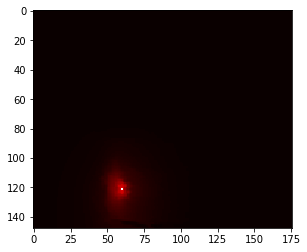

--
alpha: 2^-9
Correlation: 0.0518028155791
Score: 0.0318883598997
Heatmap:



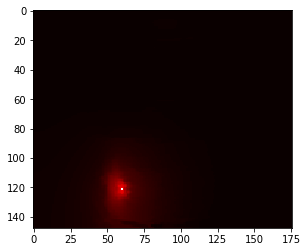

--
alpha: 2^-10
Correlation: 0.0309295740441
Score: 0.018462779414
Heatmap:



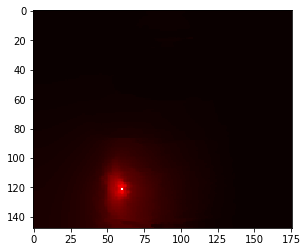

--
alpha: 2^-11
Correlation: 0.018429896141
Score: 0.0107024832545
Heatmap:



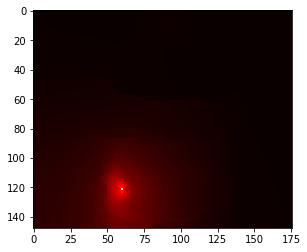

--
alpha: 2^-12
Correlation: 0.0116764957591
Score: 0.00663731272397
Heatmap:



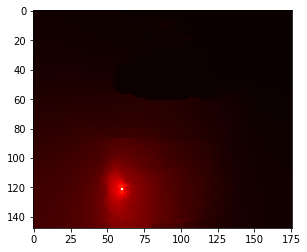

--
alpha: 2^-13
Correlation: 0.0077447246536
Score: 0.00433300669095
Heatmap:



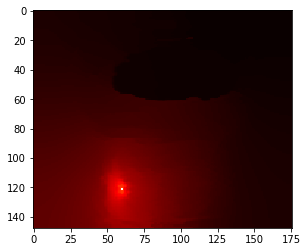

--
alpha: 2^-14
Correlation: 0.00611799315681
Score: 0.00339855582094
Heatmap:



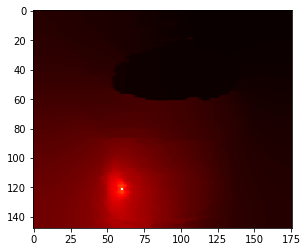

--
alpha: 2^-15
Correlation: 0.00499797480352
Score: 0.00276362819854
Heatmap:



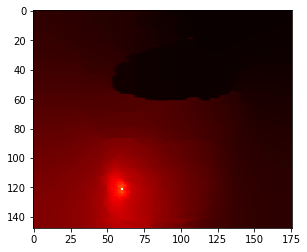

--
alpha: 2^-16
Correlation: 0.00432102747885
Score: 0.00238363930872
Heatmap:



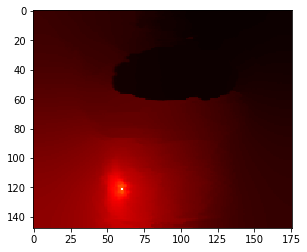

--
alpha: 2^-17
Correlation: 0.00459670573879
Score: 0.0025374124401
Heatmap:



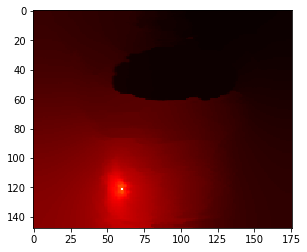

****


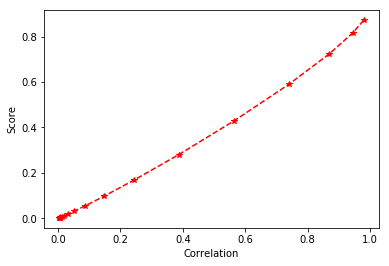

--------Seed [121, 92]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.980193973242
Score: 0.885238421885
Heatmap:



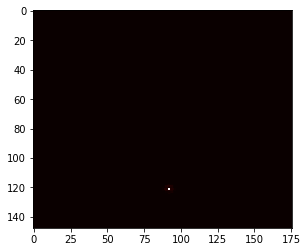

--
alpha: 2^-1
Correlation: 0.947433865055
Score: 0.832726570835
Heatmap:



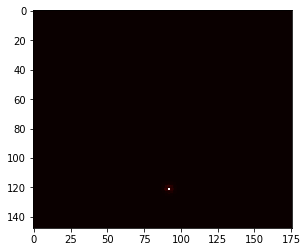

--
alpha: 2^-2
Correlation: 0.878721905021
Score: 0.747307898158
Heatmap:



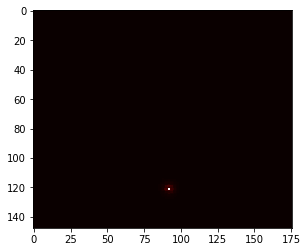

--
alpha: 2^-3
Correlation: 0.758463625482
Score: 0.621326087962
Heatmap:



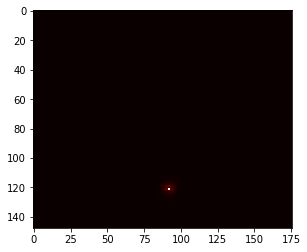

--
alpha: 2^-4
Correlation: 0.589534365958
Score: 0.463599466803
Heatmap:



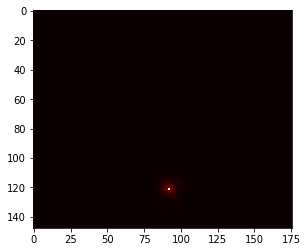

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.406848030613
Score: 0.306443535202
Heatmap:



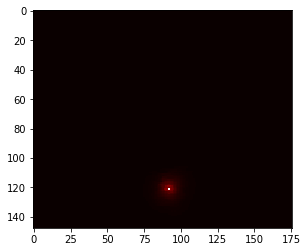

--
alpha: 2^-6
Correlation: 0.252178180817
Score: 0.181646955961
Heatmap:



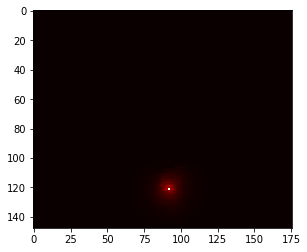

--
alpha: 2^-7
Correlation: 0.143513248849
Score: 0.0986711741858
Heatmap:



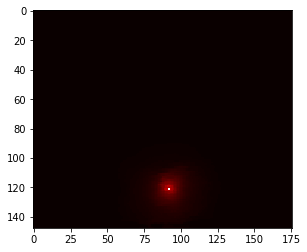

--
alpha: 2^-8
Correlation: 0.0763372050976
Score: 0.0499266485609
Heatmap:



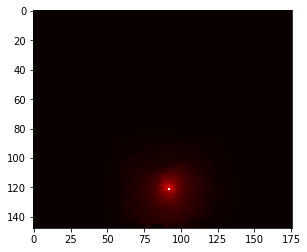

--
alpha: 2^-9
Correlation: 0.0397074227262
Score: 0.0246489112592
Heatmap:



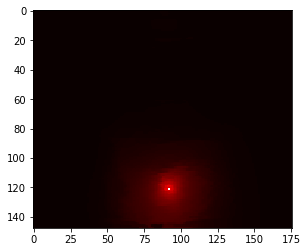

--
alpha: 2^-10
Correlation: 0.0221450876704
Score: 0.0131192383382
Heatmap:



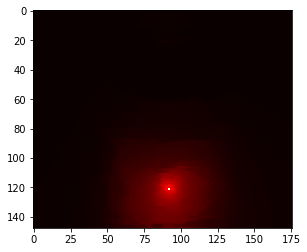

--
alpha: 2^-11
Correlation: 0.013329584859
Score: 0.00760199604131
Heatmap:



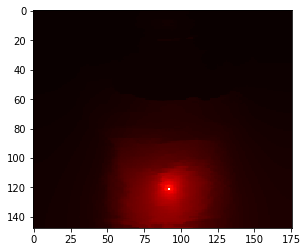

--
alpha: 2^-12
Correlation: 0.00880180047347
Score: 0.00488854139021
Heatmap:



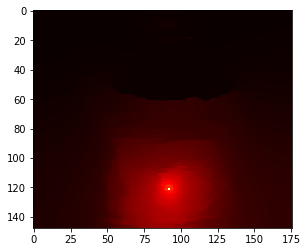

--
alpha: 2^-13
Correlation: 0.00660738383072
Score: 0.00361792829346
Heatmap:



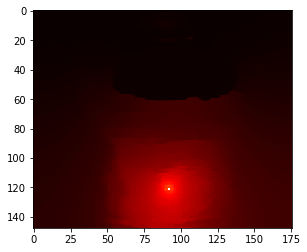

--
alpha: 2^-14
Correlation: 0.00549823498544
Score: 0.0029894745059
Heatmap:



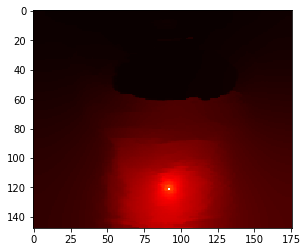

--
alpha: 2^-15
Correlation: 0.0048912048575
Score: 0.00265174710815
Heatmap:



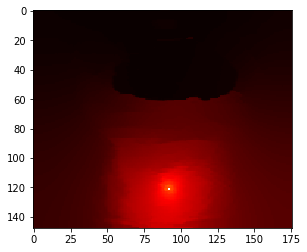

--
alpha: 2^-16
Correlation: 0.00459232514888
Score: 0.00248652863471
Heatmap:



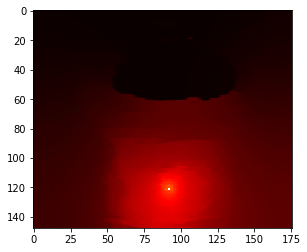

--
alpha: 2^-17
Correlation: 0.00434707049426
Score: 0.00235131476148
Heatmap:



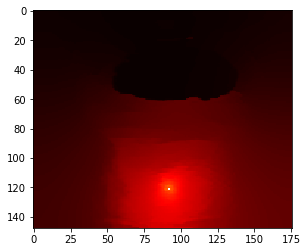

--
alpha: 2^-18
Correlation: 0.00421402900409
Score: 0.00227926870979
Heatmap:



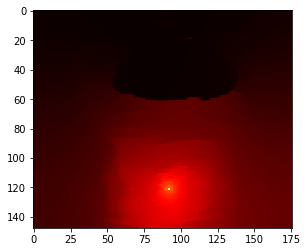

--
alpha: 2^-19
Correlation: 0.00435599807114
Score: 0.00235565106351
Heatmap:



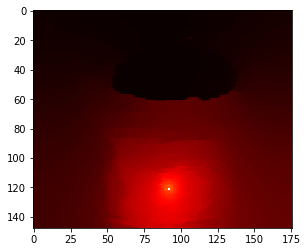

****


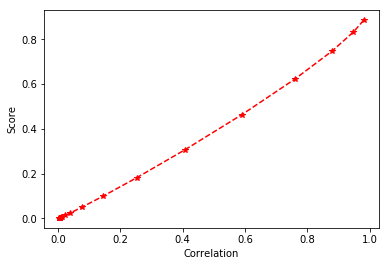

--------Seed [121, 124]
Threshold: 3.839066339066339e-05
--
alpha: 2^0
Correlation: 0.979091763233
Score: 0.885020360872
Heatmap:



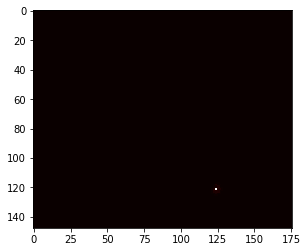

--
alpha: 2^-1
Correlation: 0.942474772665
Score: 0.826321030679
Heatmap:



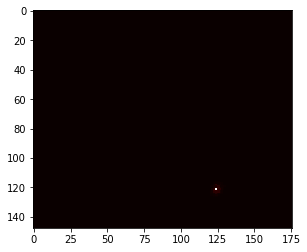

--
alpha: 2^-2
Correlation: 0.862719997364
Score: 0.727243650771
Heatmap:



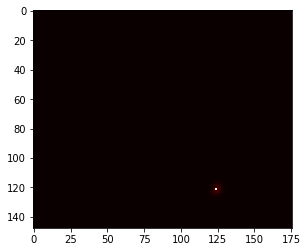

--
alpha: 2^-3
Correlation: 0.724424114418
Score: 0.582879212119
Heatmap:



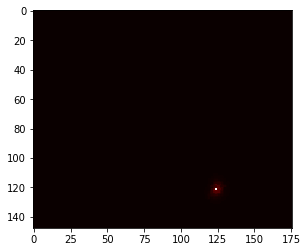

--
alpha: 2^-4
Correlation: 0.545012433394
Score: 0.41695272194
Heatmap:



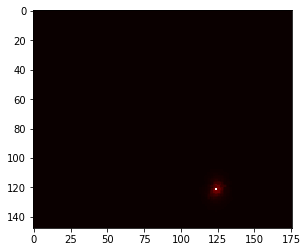

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.370807090206
Score: 0.26970144989
Heatmap:



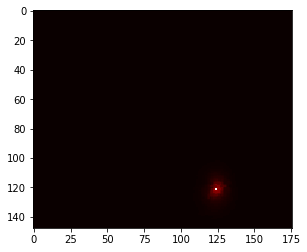

--
alpha: 2^-6
Correlation: 0.235009742094
Score: 0.162887509791
Heatmap:



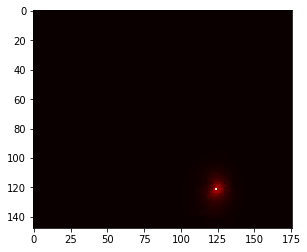

--
alpha: 2^-7
Correlation: 0.142196830198
Score: 0.0942063340275
Heatmap:



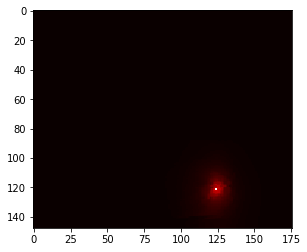

--
alpha: 2^-8
Correlation: 0.0833265179387
Score: 0.0529117195594
Heatmap:



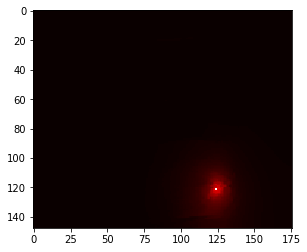

--
alpha: 2^-9
Correlation: 0.0470220690091
Score: 0.0286428618971
Heatmap:



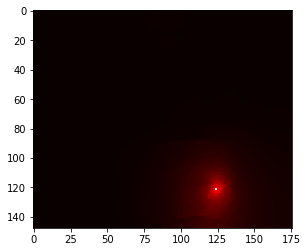

--
alpha: 2^-10
Correlation: 0.0251873634486
Score: 0.0146928249155
Heatmap:



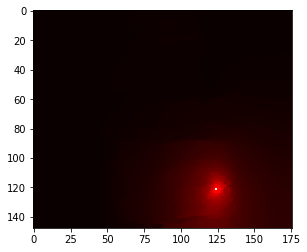

--
alpha: 2^-11
Correlation: 0.0134334193648
Score: 0.0075080218843
Heatmap:



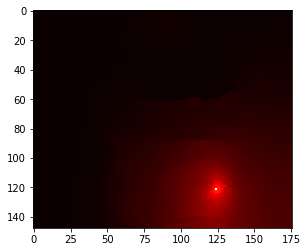

--
alpha: 2^-12
Correlation: 0.00807807550665
Score: 0.0043679023343
Heatmap:



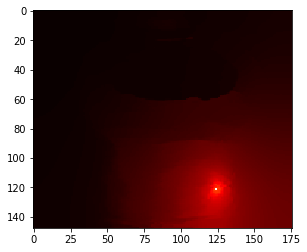

--
alpha: 2^-13
Correlation: 0.00538664028382
Score: 0.00284592996921
Heatmap:



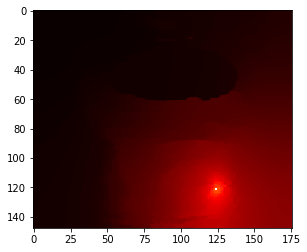

--
alpha: 2^-14
Correlation: 0.00402254529131
Score: 0.00209628750978
Heatmap:



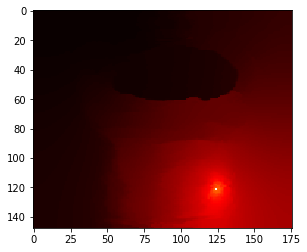

--
alpha: 2^-15
Correlation: 0.00343007087498
Score: 0.00177896520816
Heatmap:



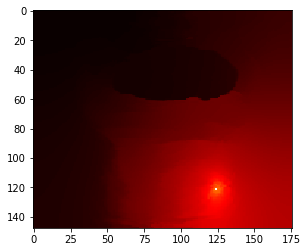

--
alpha: 2^-16
Correlation: 0.00316827857129
Score: 0.00164065500174
Heatmap:



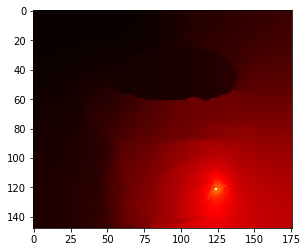

--
alpha: 2^-17
Correlation: 0.00299593572444
Score: 0.0015500348558
Heatmap:



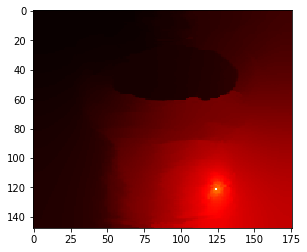

--
alpha: 2^-18
Correlation: 0.00287524542062
Score: 0.00148673304973
Heatmap:



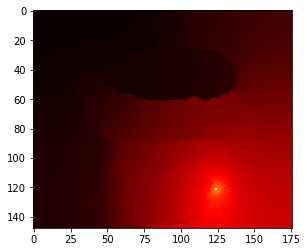

--
alpha: 2^-19
Correlation: 0.00285289109487
Score: 0.00147500908058
Heatmap:



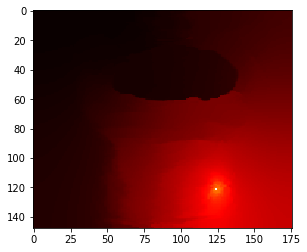

****


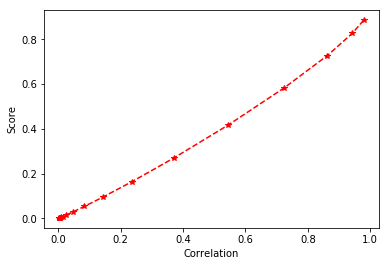

In [6]:
for elem in seedList[2:]:
    print('--------Seed ' + str(elem))
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    
    [alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

    # Saving
    alphaListList.append(alphaList)
    correlationListList.append(correlationList)
    scoreListList.append(scoreList)
    valueListList.append(valueList)

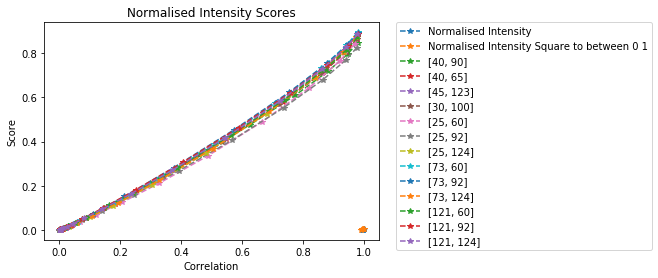

In [7]:
for i in range(len(correlationListList)):
    plt.plot(correlationListList[i], scoreListList[i], '*--')
plt.legend(seedList, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

In [8]:
save_array(IMAGE + '/' + 'alphaListList.data', alphaListList)
save_array(IMAGE + '/' + 'correlationListList.data', correlationListList)
save_array(IMAGE + '/' + 'scoreListList.data', scoreListList)
save_array(IMAGE + '/' + 'valueListList.data', valueListList)
save_array(IMAGE + '/' + 'seedList.data', seedList[2:])

In [9]:
alphaListListRecovered = load_array(IMAGE + '/' + 'alphaListList.data')
correlationListListRecovered = load_array(IMAGE + '/' + 'correlationListList.data')
scoreListListRecovered = load_array(IMAGE + '/' + 'scoreListList.data')
valueListListRecovered = load_array(IMAGE + '/' + 'valueListList.data')
seedListRecovered = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
seedListRecovered[2:] = load_array(IMAGE + '/' + 'seedList.data')

Print with saved arrays for future usage


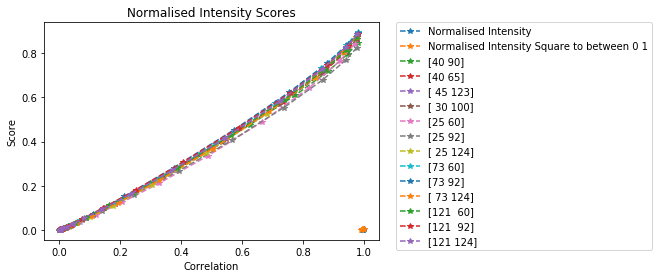

In [11]:
print('Print with saved arrays for future usage')
for i in range(len(correlationListListRecovered)):
    plt.plot(correlationListListRecovered[i], scoreListListRecovered[i], '*--')
plt.legend(seedListRecovered, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
# plt.axis([.8,1,0,1])
plt.show()